# 0.0 Imports

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import math
import datetime
import random
import pickle
import requests
import xgboost as xgb
from matplotlib import pyplot as plt
from scipy import stats as ss
from IPython.display import Image
from IPython.core.display import HTML
from matplotlib import gridspec
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from tabulate import tabulate
from boruta import BorutaPy


## 0.1 Helper functions

In [146]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr - 1, rcorr - 1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date ) ]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

In [147]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading data

In [148]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data description

## 1.1 Rename columns

In [149]:
df1 = df_raw.copy()

In [150]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [151]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [152]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data types

In [153]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [154]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.4 Check NA

In [155]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [156]:
df1['competition_distance'].max()

75860.0

In [157]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [158]:
df1.sample(10).T

,823405,468426,44894,213434,696812,34228,818843,626552,595493,634330
store,206,912,295,470,723,779,104,708,869,681
day_of_week,7,4,7,3,2,3,4,2,2,2
date,2013-06-23 00:00:00,2014-05-08 00:00:00,2015-06-21 00:00:00,2015-01-21 00:00:00,2013-10-15 00:00:00,2015-07-01 00:00:00,2013-06-27 00:00:00,2013-12-17 00:00:00,2014-01-14 00:00:00,2013-12-10 00:00:00
sales,0,5429,0,8460,5470,9804,8250,6387,4995,3540
customers,0,744,0,1200,447,800,1171,589,802,518
open,0,1,0,1,1,1,1,1,1,1
promo,0,1,0,0,0,1,0,1,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,1,0,1,0,0,0
store_type,a,c,a,a,d,a,a,c,c,a


## 1.6 Change Type

In [159]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [160]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive statistics

In [161]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [162]:
num_attributes.agg(['mean', 'median', 'std', 'min', 'max', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


### 1.7.1 Categorical attributes

In [163]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

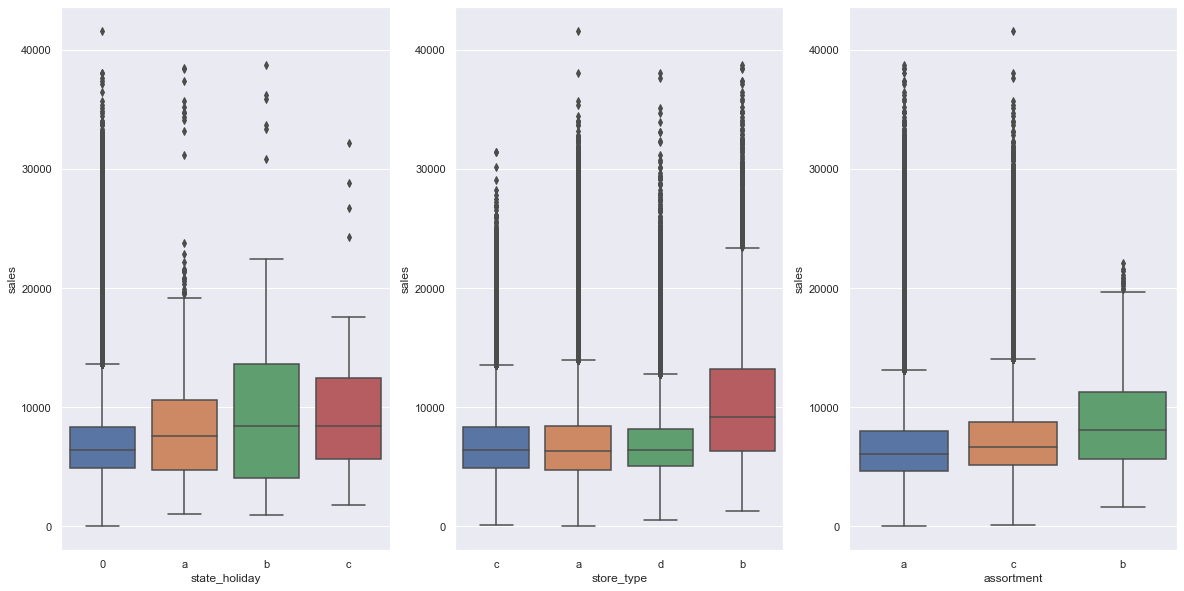

In [164]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0 Feature Engineering

In [165]:
df2 = df1.copy()

## 2.1 Mind map Hypoteses

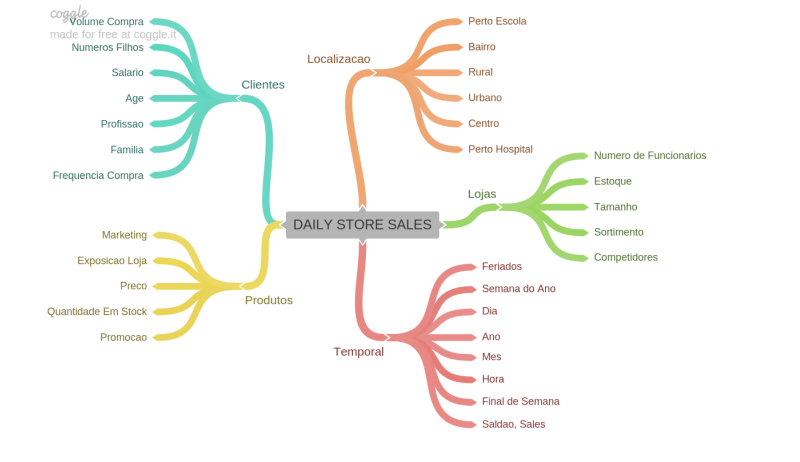

In [166]:
Image('img/mindmap.png')

## 2.2 Hypoteses

### 2.2.1 Store hypoteses

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Product hypoteses

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Time hypoteses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Final list hypotheses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [167]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [168]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Variable filtering

In [169]:
df3 = df2.copy()

## 3.1 Rows filtering

In [170]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns selection

In [171]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EDA

In [172]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Responsible variable

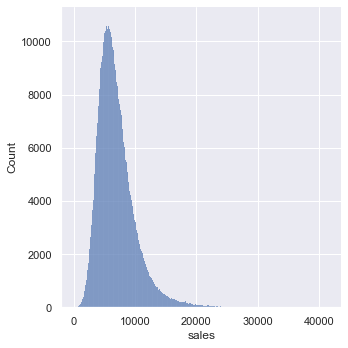

In [173]:
sns.displot(df4['sales'], kde=False);

### 4.1.2 Numerical variable

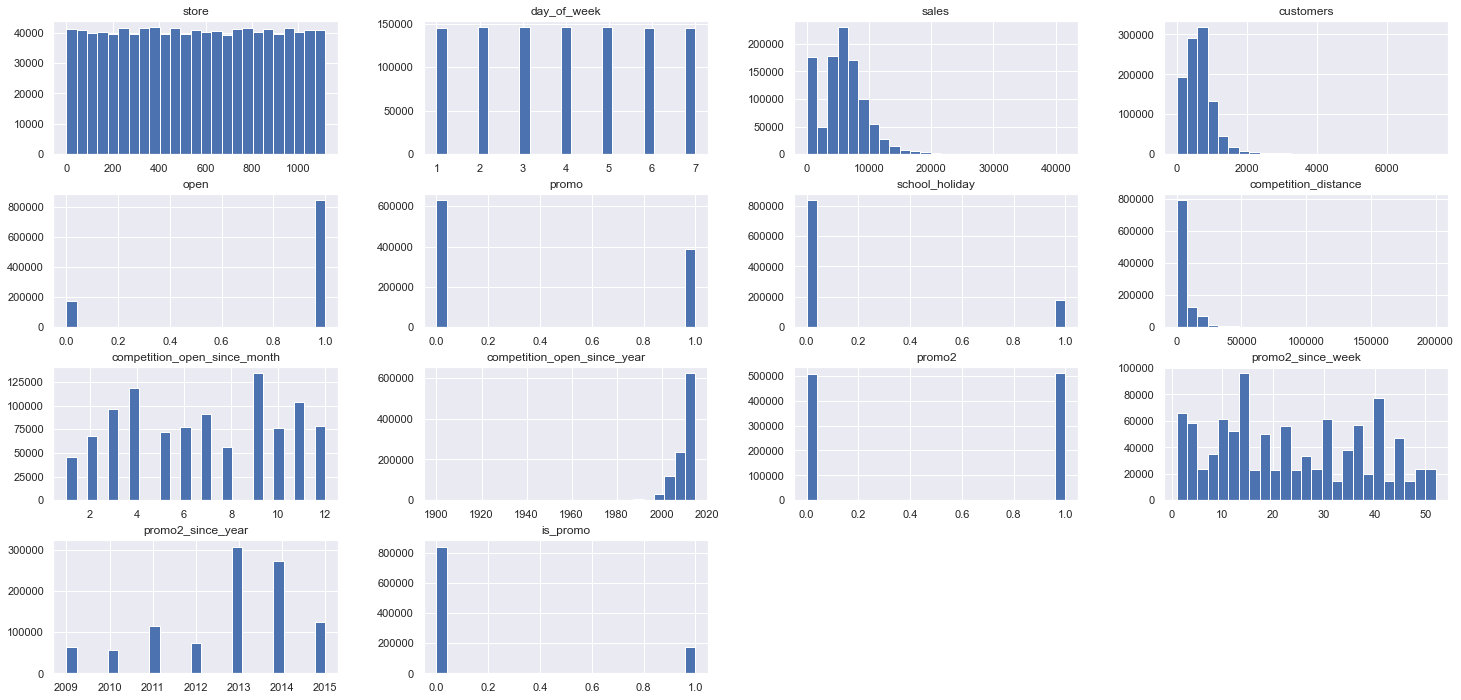

In [174]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [175]:
df4['state_holiday'].drop_duplicates()


0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

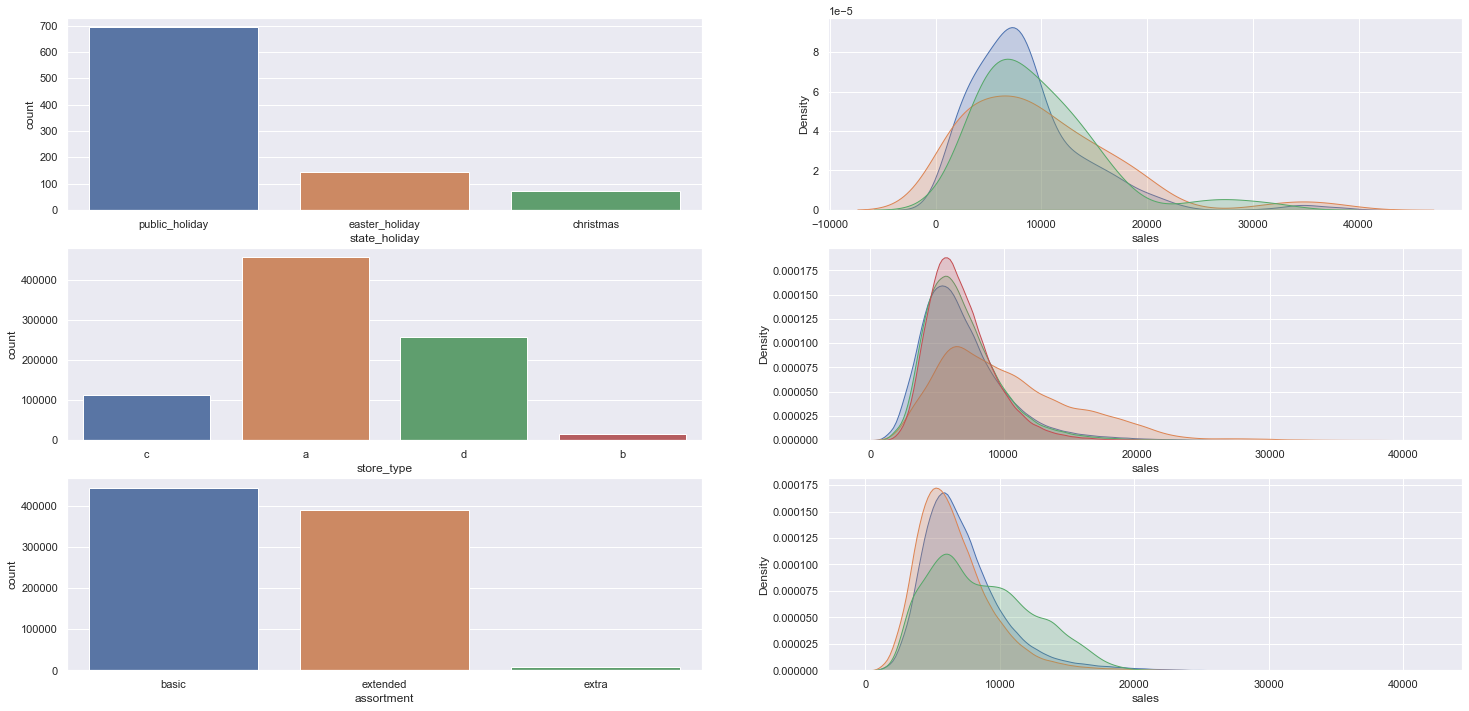

In [177]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])
plt.subplot( 3, 2, 2 )
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x=df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot(x = df4['assortment'])
plt.subplot( 3, 2, 6 )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 4.2 Bivariate analysis

### **H1:** Lojas com maior sortimentos deveriam vender mais.
***FALSA*** Lojas com maor numero de sortimentos vendem menos.

<AxesSubplot:xlabel='year_week'>

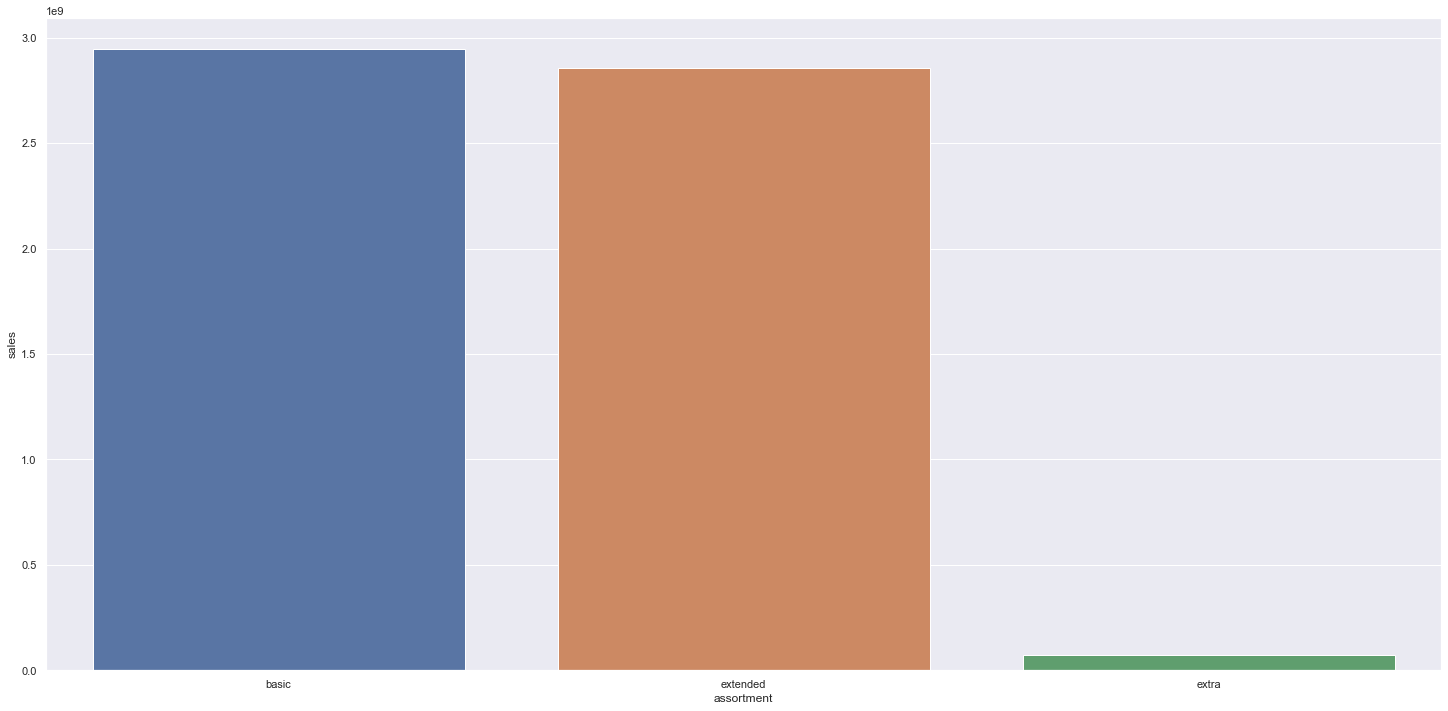

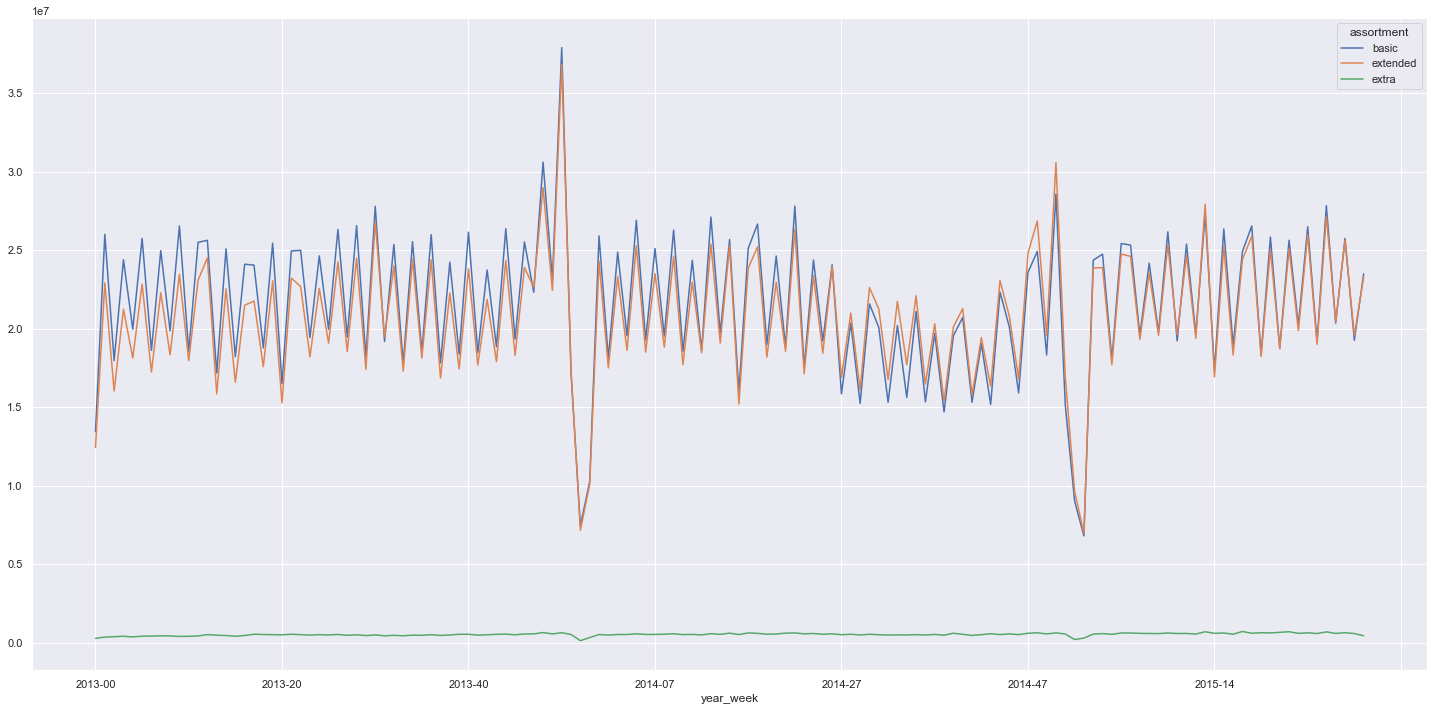

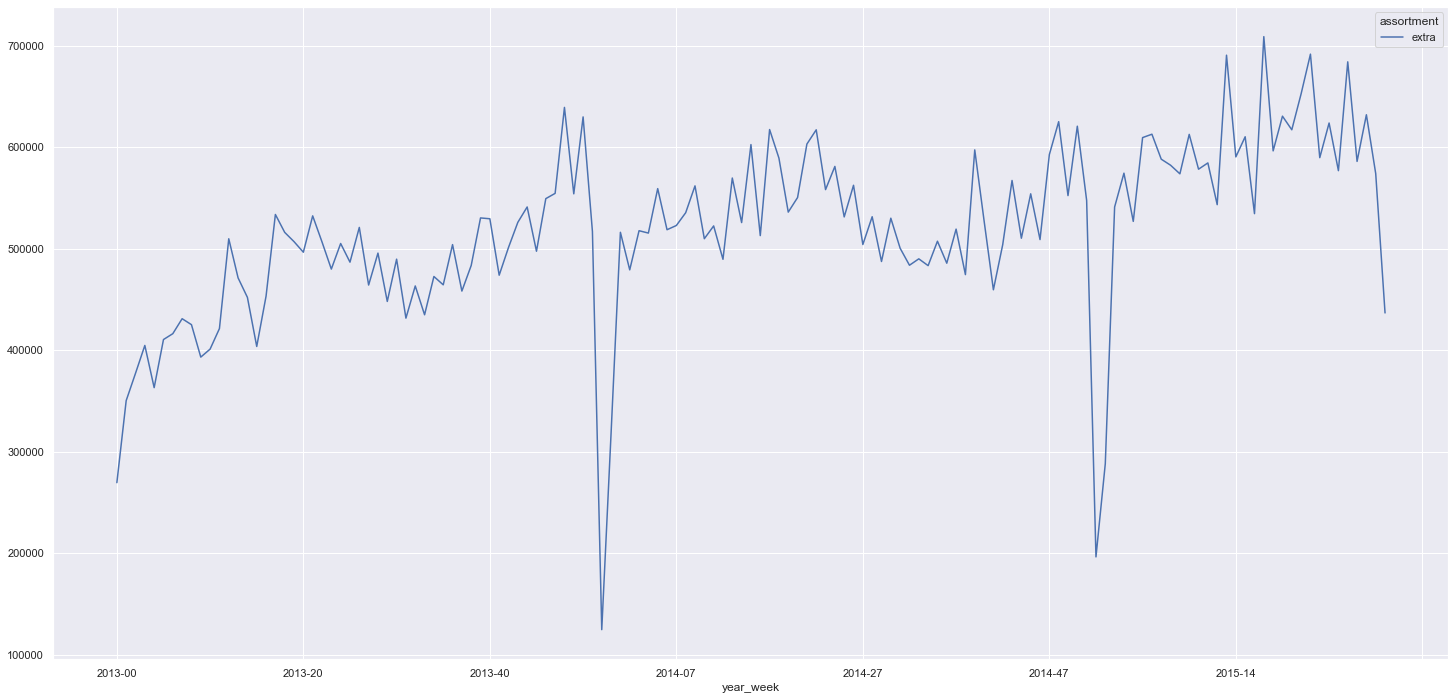

In [178]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


### **H2:** Lojas com competidores mais próximos deveriam vender menos.
***FALSA*** Lojas com competidores mais próximos vendem mais.


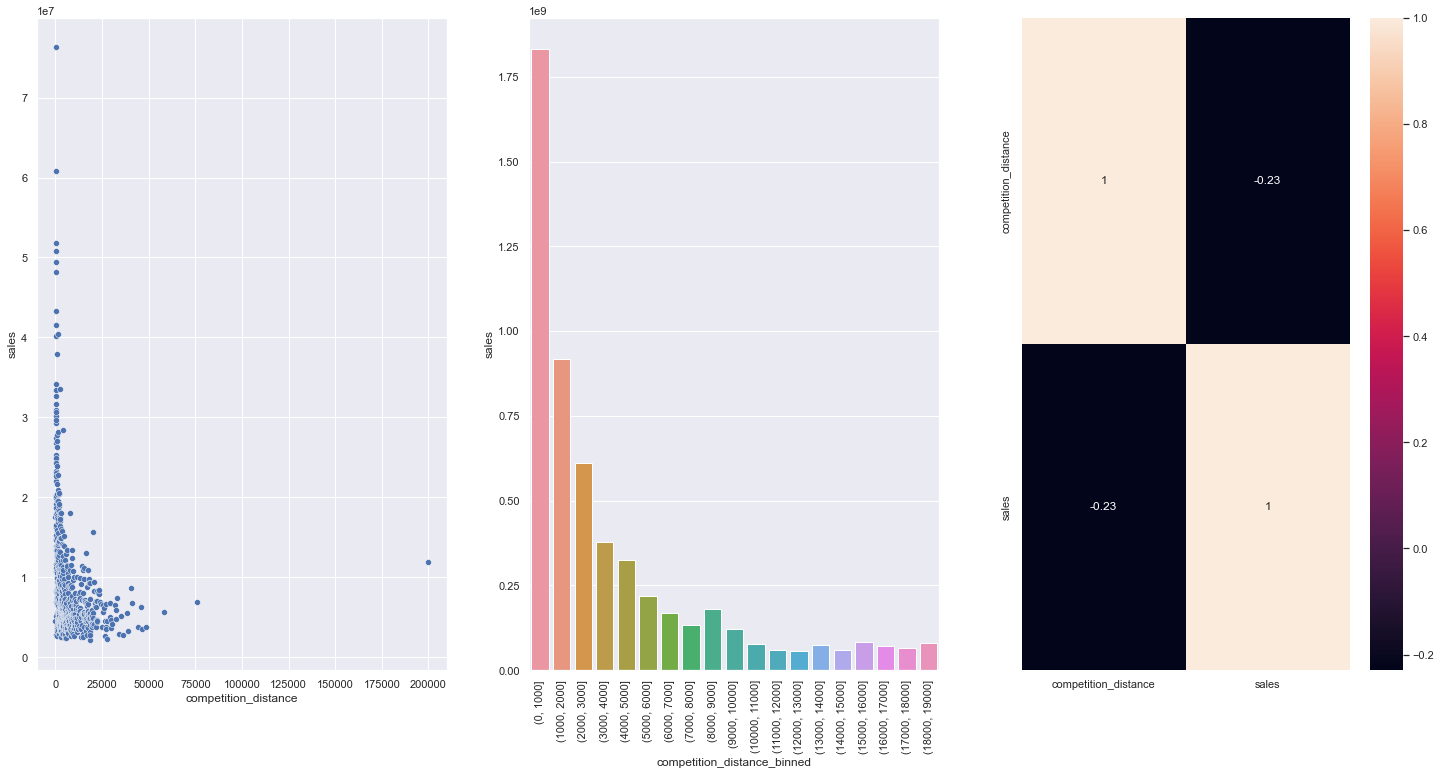

In [180]:
aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux4);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins=bins)
aux5 = aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux5);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 3)
sns.heatmap(aux4.corr(method='pearson'), annot=True);


### **H3:** Lojas com competidores à mais tempo deveriam vendem mais.
***FALSA*** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

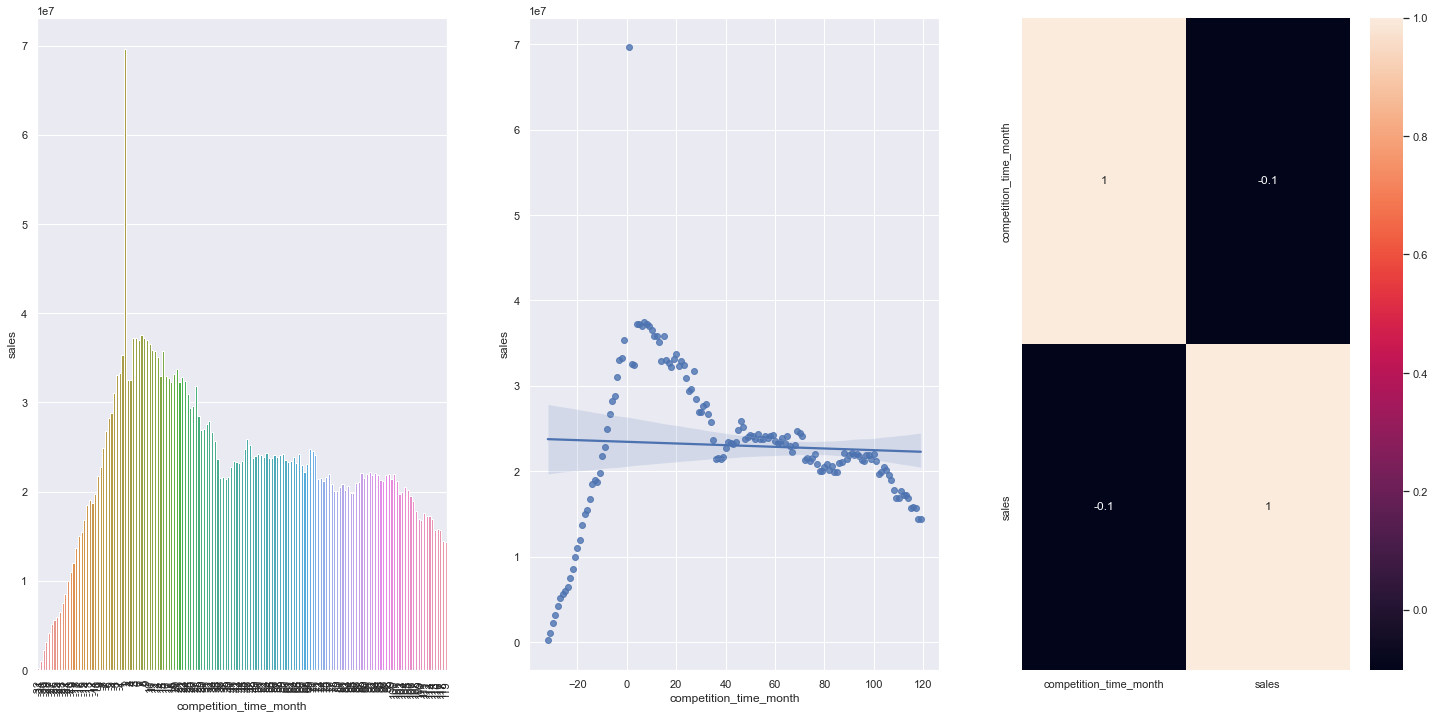

In [181]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot( 1, 3, 2 )
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);

**H4:** Lojas com promoções ativas por mais tempo deveriam vender mais.

***FALSA*** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao.


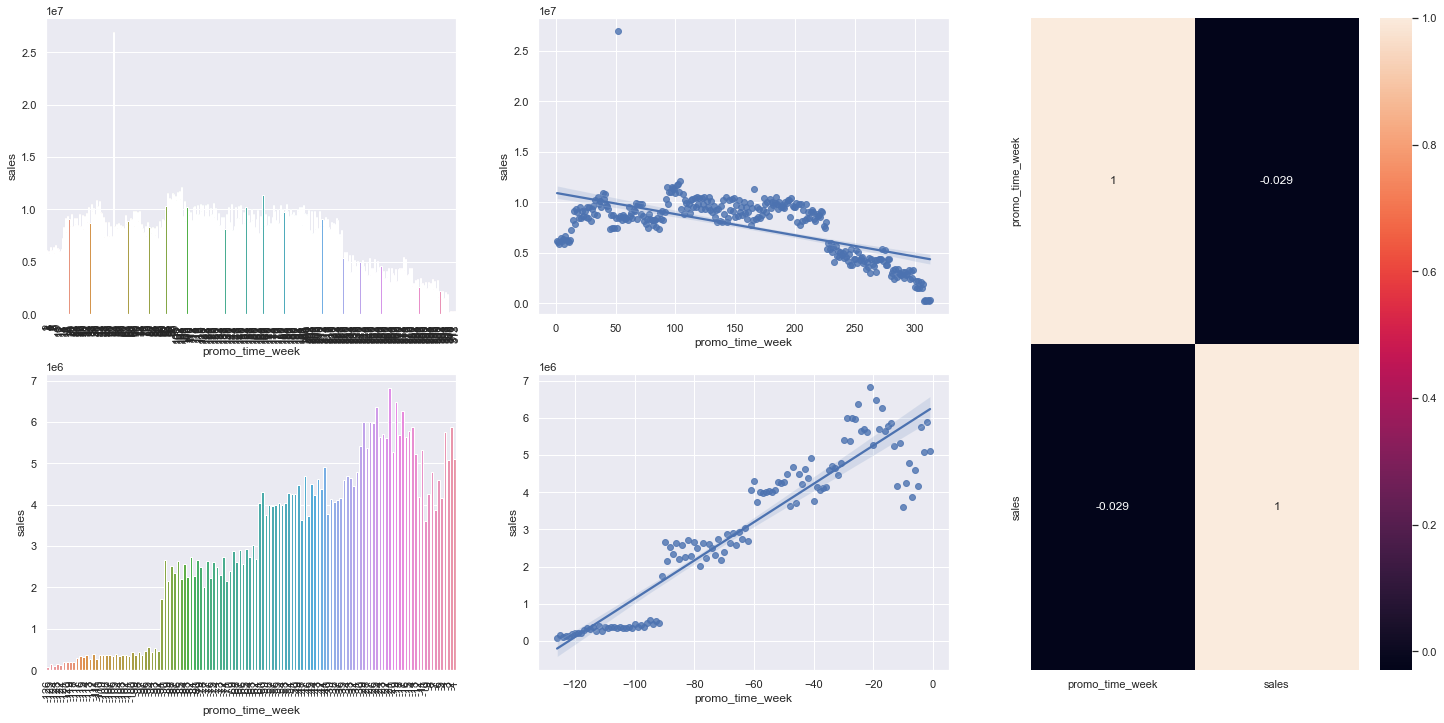

In [182]:


aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)# two lines and 3 columns

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]# prom extended
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]# regular prom
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot=True);

<s>**H5:** Lojas com mais dias de promoção deveriam vender mais.<s>

**H6:** Lojas com mais promoções consecutivas deveriam vender mais.

***FALSA*** Lojas com mais promocoes consecutivas vendem menos

In [183]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


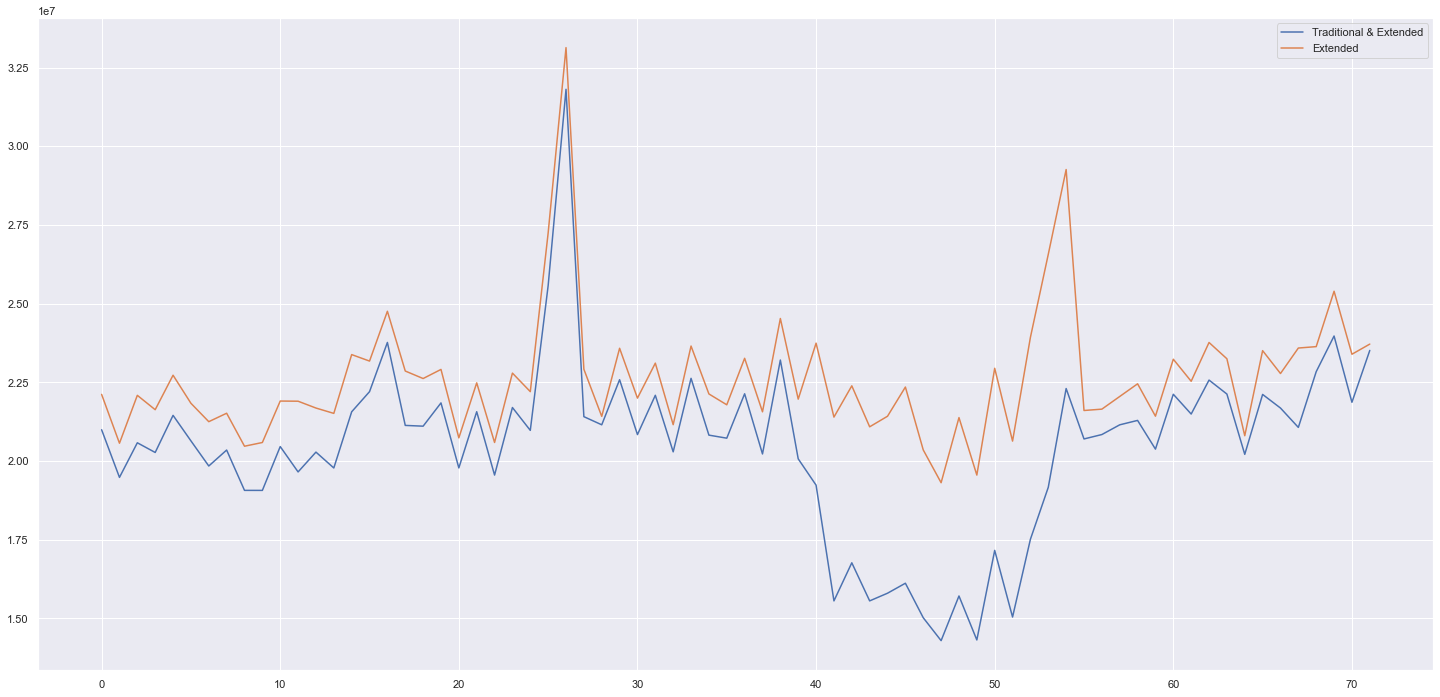

In [184]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Traditional & Extended', 'Extended']);

**H7:** Lojas abertas durante o feriado de Natal deveriam vender mais.

***FALSA*** Lojas abertas durante o feriado do Natal vendem menos.



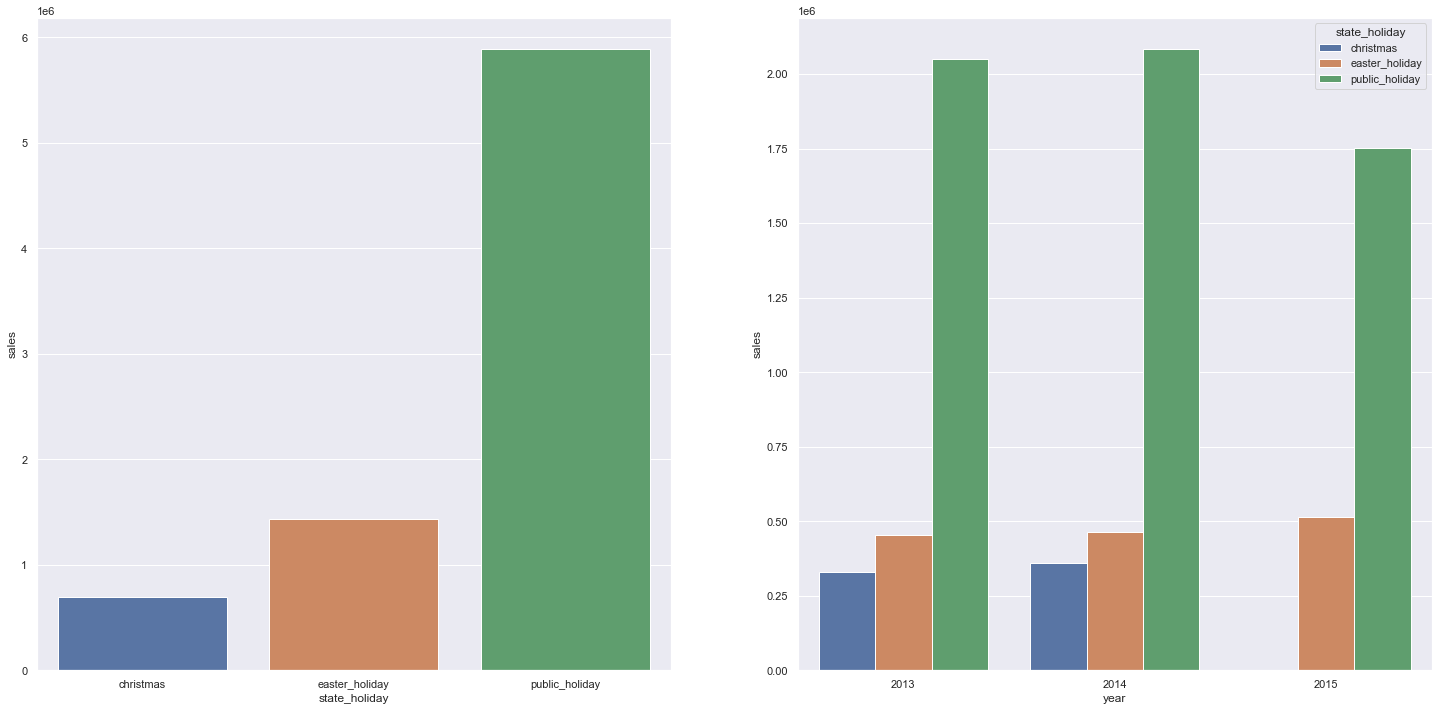

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

**H8:** Lojas deveriam vender mais ao longo dos anos.

***FALSA*** Lojas vendem menos ao longo dos anos


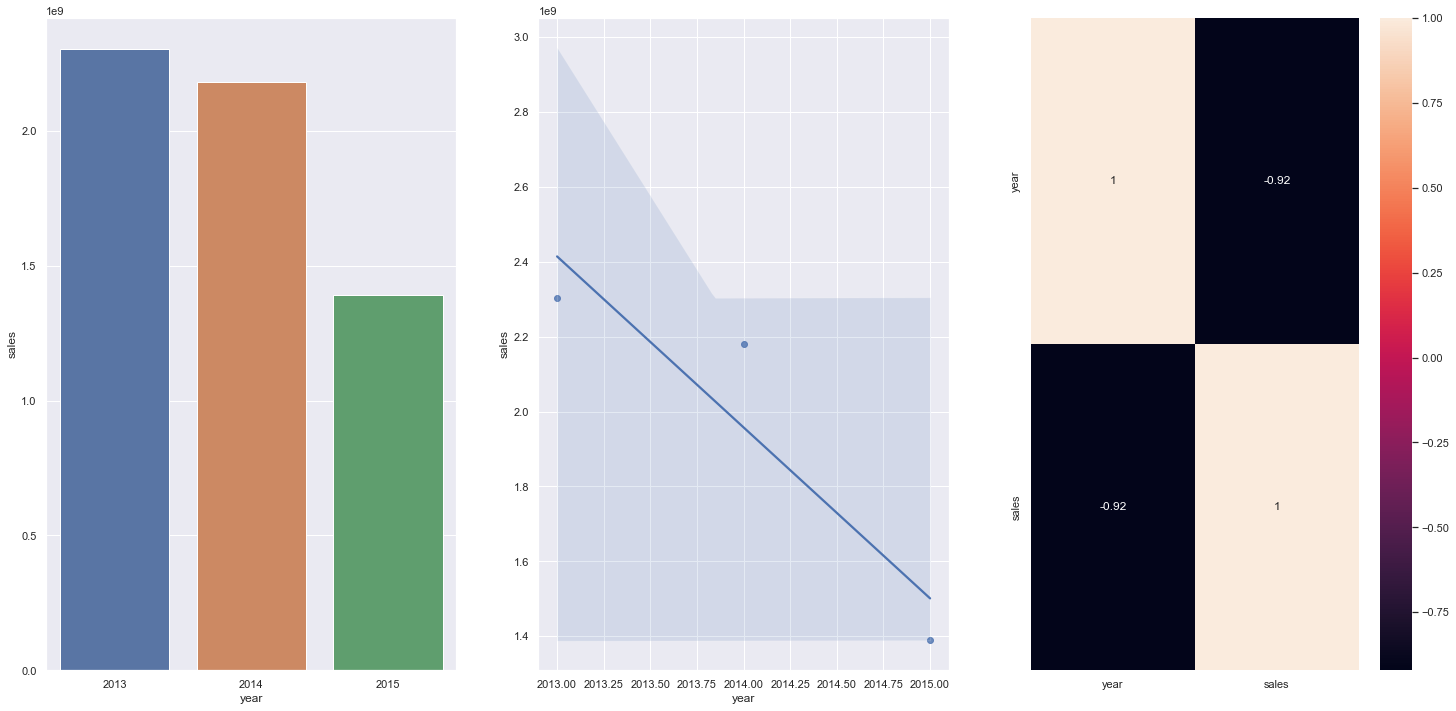

In [186]:
# aux = df4[df4['year'] < 2015]
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr( method='pearson' ), annot=True);

**H9:** Lojas deveriam vender mais no segundo semestre do ano.

***FALSA*** Lojas vendem menos no segundo semestre do ano

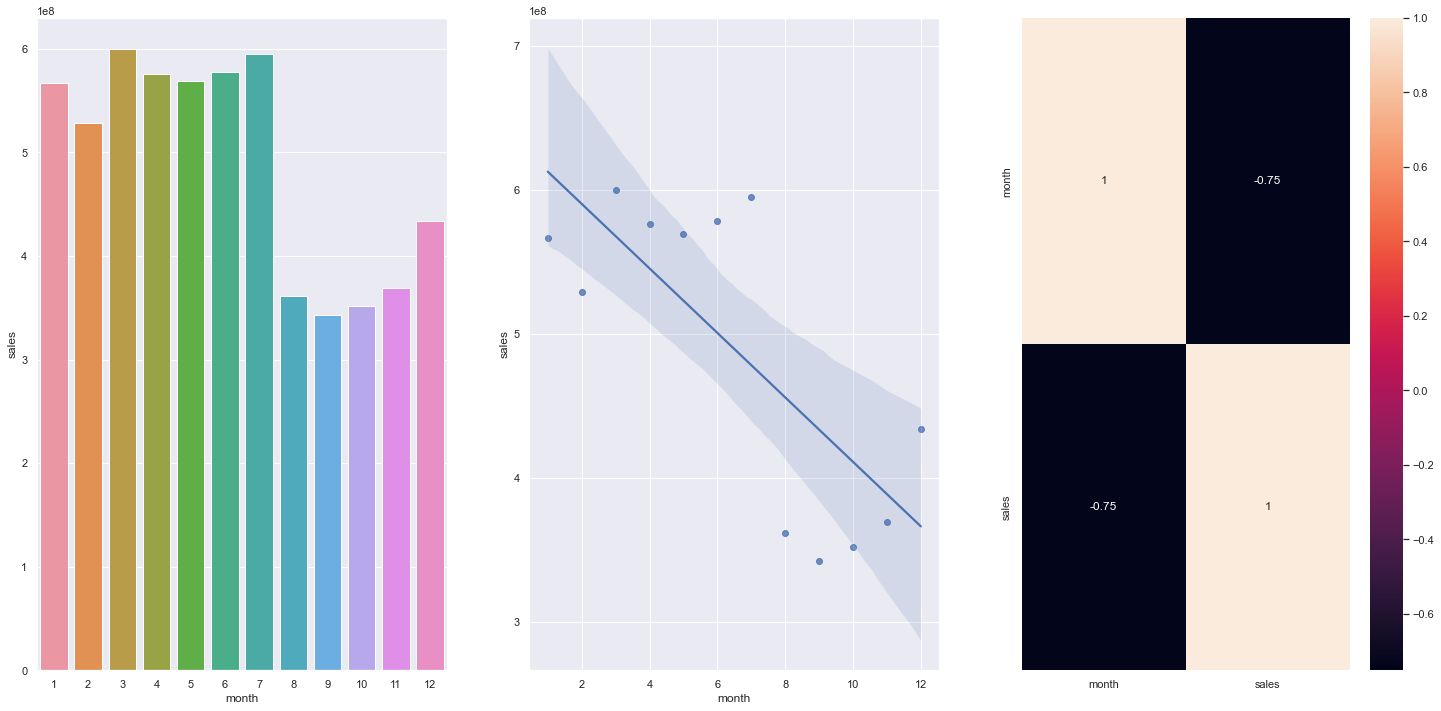

In [187]:
# aux = df4[df4['year'] < 2015]
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr( method='pearson' ), annot=True);


**H10:** Lojas deveriam vender mais depois do dia 10 de cada mês.

***VERDADEIRA*** Lojas vendem MAIS depois do dia 10 de cada mês.


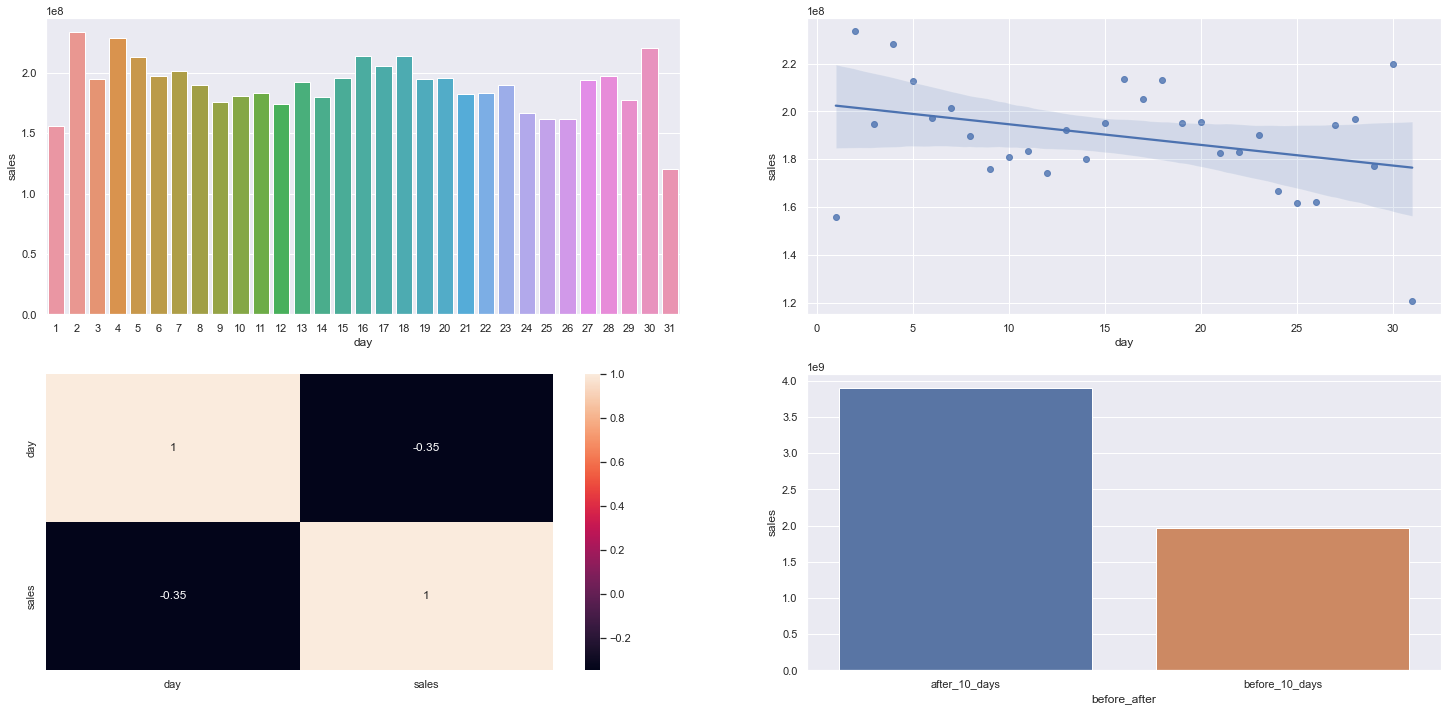

In [188]:
# aux = df4[df4['year'] < 2015]
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot( 2, 2, 3 )
sns.heatmap(aux1.corr( method='pearson' ), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot(x='before_after', y='sales', data=aux2);

**H11:** Lojas deveriam vender menos aos finais de semana.

***VERDADEIRA*** Lojas vendem menos nos final de semana


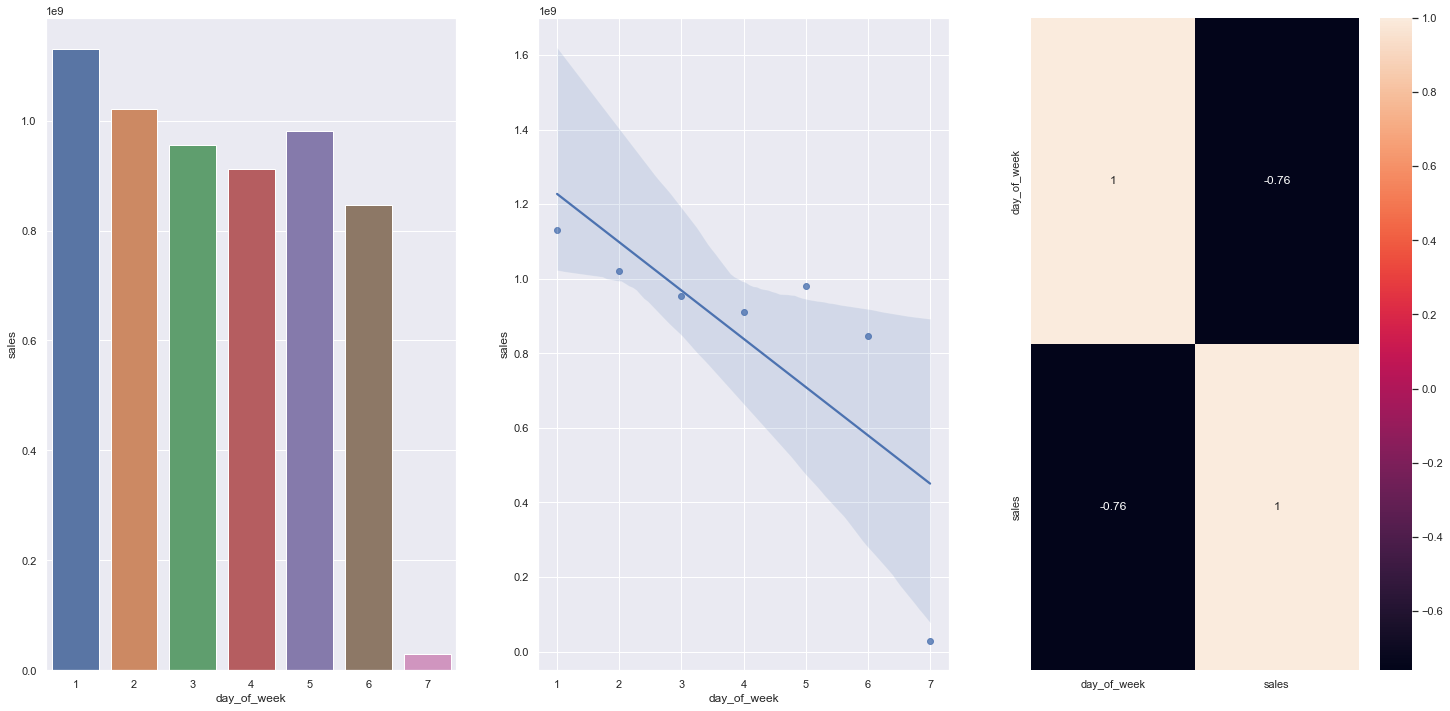

In [189]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr( method='pearson' ), annot=True);

**H12:** Lojas deveriam vender menos durante os feriados escolares

***VERDADEIRA*** Lojas vendem menos durante os feriadso escolares, exceto no mês de Agosto.

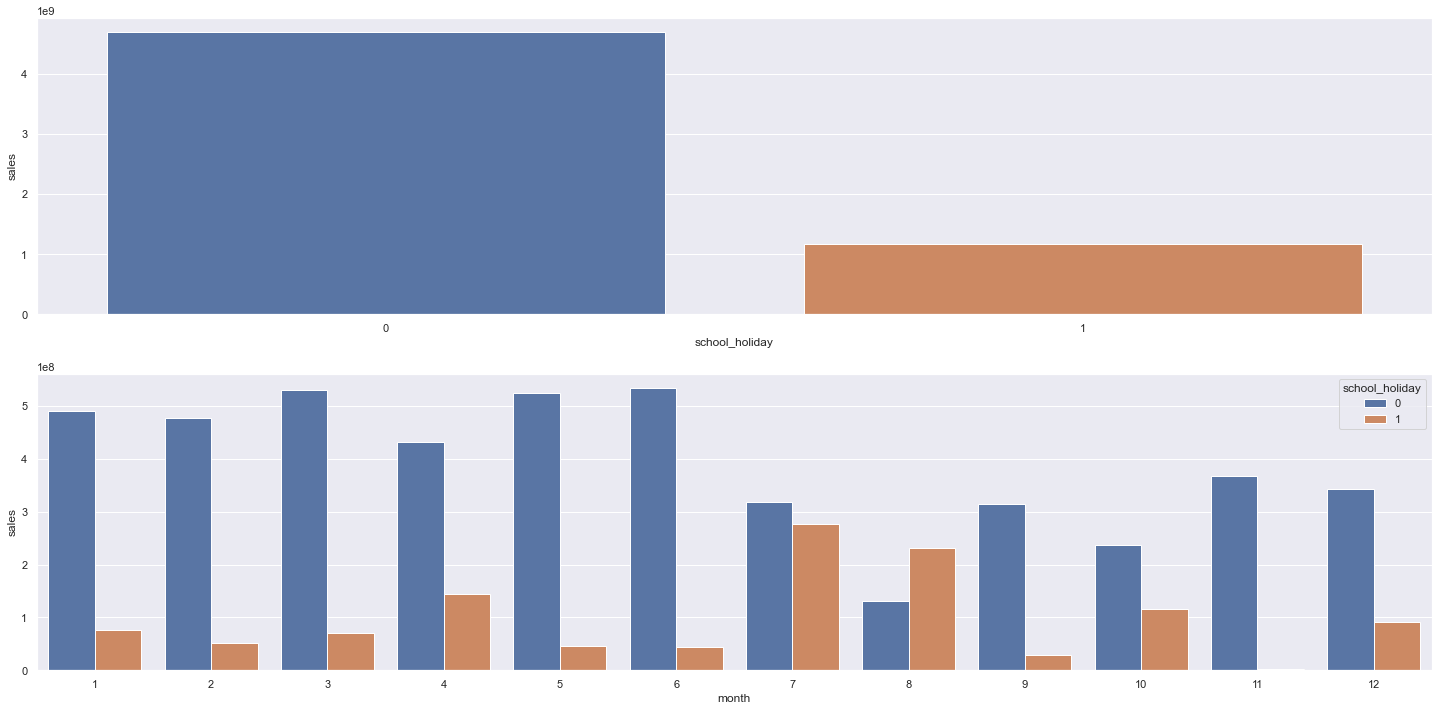

In [190]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot(2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2 )
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Summary

In [191]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta']]

print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta


## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

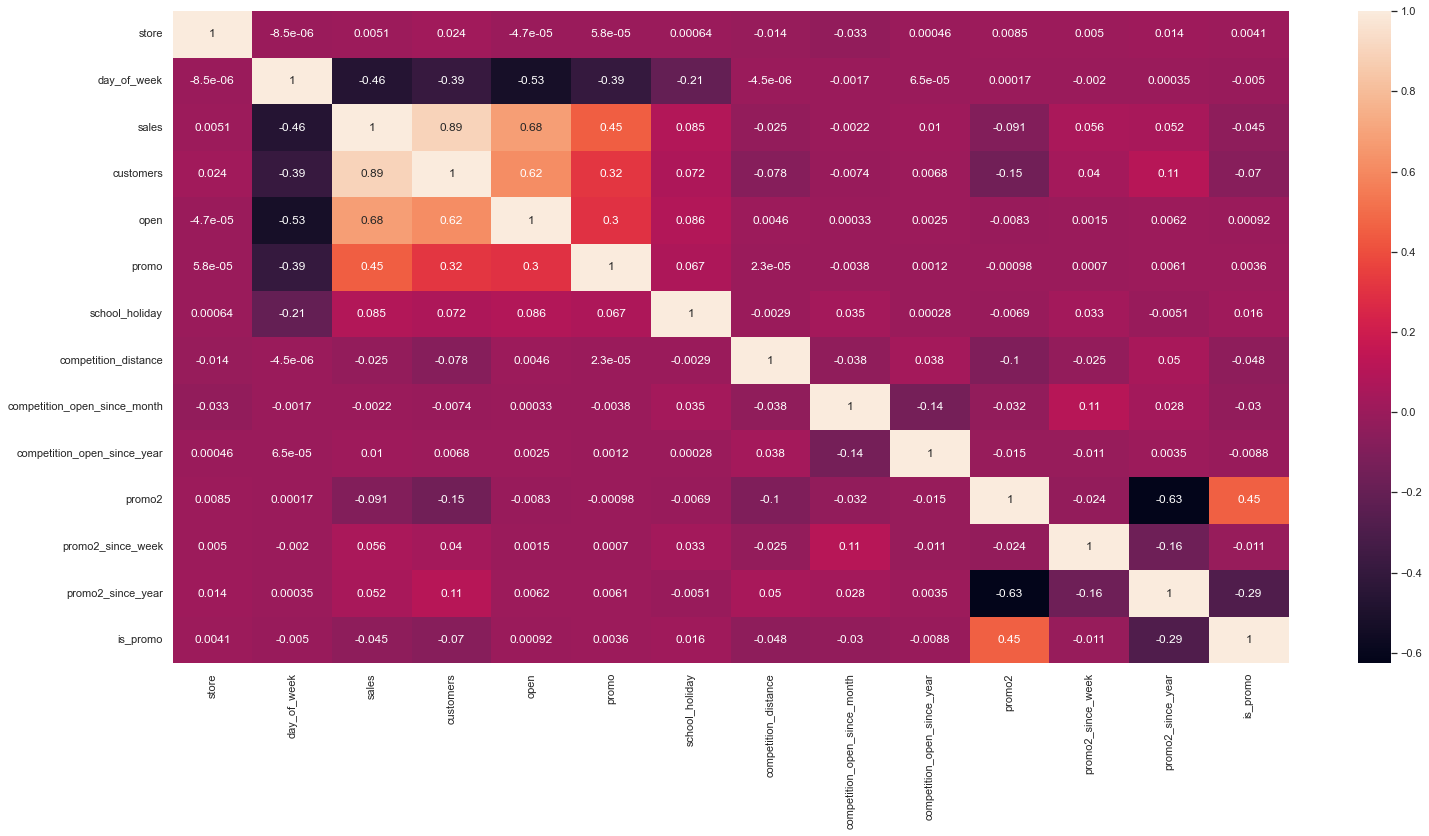

In [192]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

<AxesSubplot:>

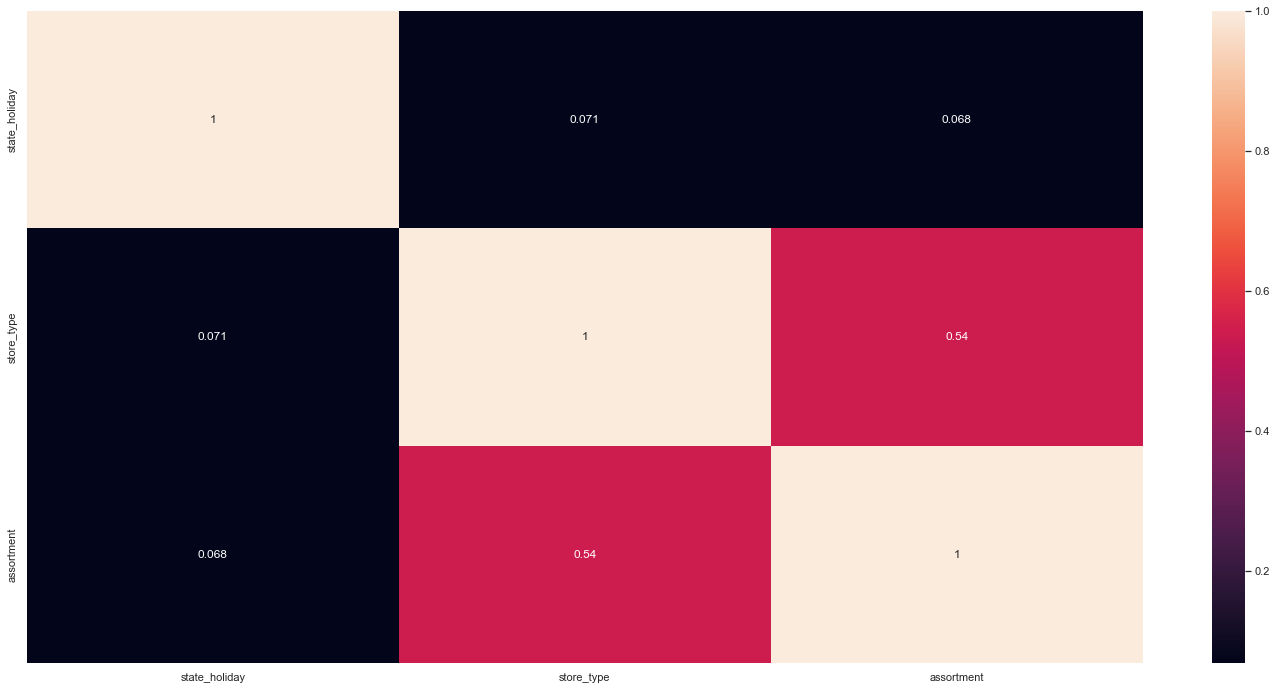

In [193]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [194]:
df5 = df4.copy()

# convert columns int32 to int64 
df5['week_of_year'] = df5['week_of_year'].astype('int64')
df5['competition_time_month'] = df5['competition_time_month'].astype('int64')
df5['promo_time_week'] = df5['promo_time_week'].astype('int64')


## 5.1 Normalization

## 5.2 Rescaling

In [195]:
a = df5.select_dtypes(include=['int64', 'float'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


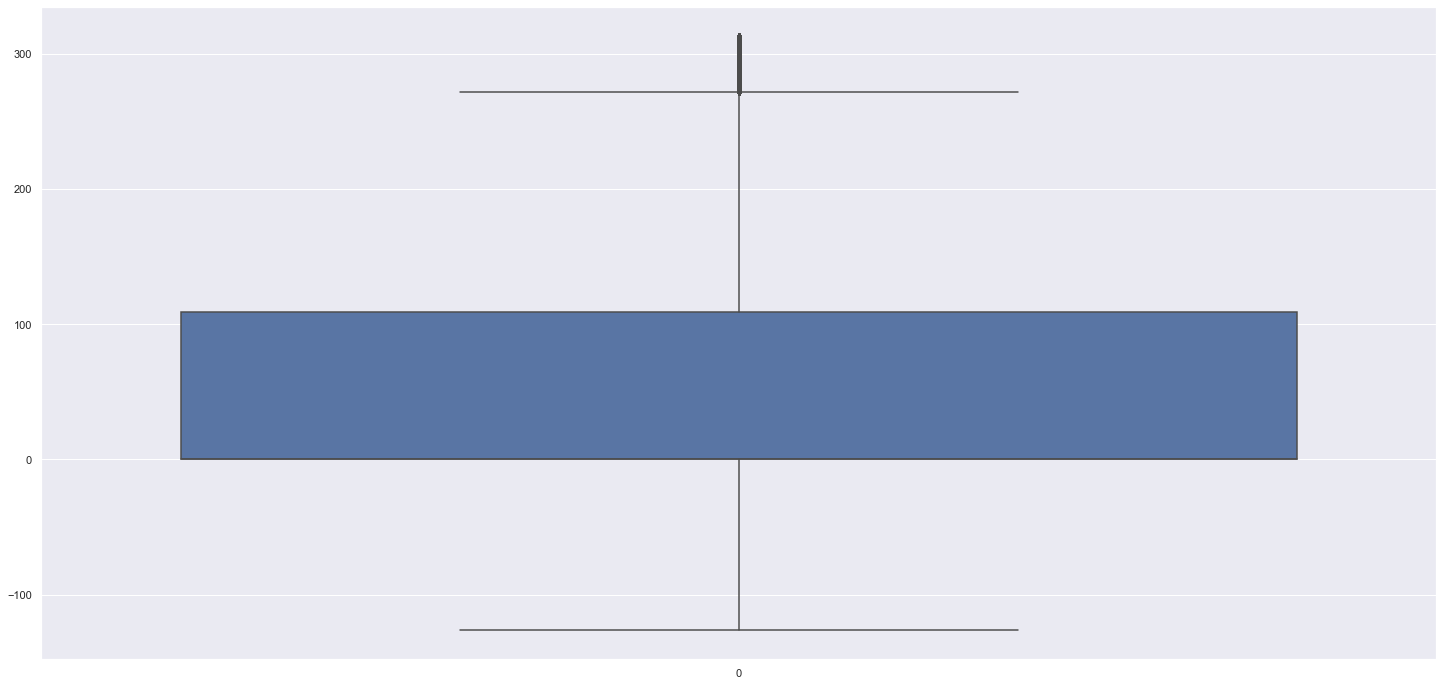

In [196]:
# check outliers, choose method (robust Scaler / MinMaxScaler)
sns.boxplot(data= df5['promo_time_week']);

In [197]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump ( rs, open( '\\Users\Codo\\Desktop\\repos\\Ds_producao\\parameter\\competition_distance_scaler.pkl', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump ( rs, open( '\\Users\Codo\\Desktop\\repos\\Ds_producao\\parameter\\competition_time_month_scaler.pkl', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump ( mms, open( '\\Users\Codo\\Desktop\\repos\\Ds_producao\\parameter\\promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump ( mms, open( '\\Users\Codo\\Desktop\\repos\\Ds_producao\\parameter\\year_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1 Enconding

In [198]:
# state_holiday - one hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump ( le, open( '\\Users\Codo\\Desktop\\repos\\Ds_producao\\parameter\\store_type_scaler.pkl', 'wb' ) )

# assortment - ordinary enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [199]:
df5['sales'] = np.log1p(df5['sales'])


### 5.3.3 Nature Transformation

In [200]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ))) 
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 )))

In [201]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [204]:
df6 = df5.copy()

## 6.1 Split dataframe into training an test dataset

In [205]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [206]:
# selection last 6 weeks
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [207]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [59]:
# training dataset
#x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, ).fit( x_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [60]:
# cols_selected = boruta.support_.tolist()

# columns selected
# x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# columns not selected
# cols_not_selected_boruta = list(np.setdiff1d( x_train_fs.columns, cols_selected_boruta ))

## 6.3 Manual Feature Selection

In [208]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_cos']

cols_not_selected_boruta = [
    'is_promo',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'week_of_year_sin',
    'year'] 

# columns to add
feat_to_add = ['date', 'sales' ]

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )



# 7.0 Machine Learning Modelling

In [209]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# time series data preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [210]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression

In [211]:
# model
lr = LinearRegression().fit( x_train, y_train)

# predictions
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) ) 
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.313299,0.292392,2674.576594


### 7.2.1 Linear Regression - Cross validation

In [212]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.69 +/- 293.36,0.3 +/- 0.02,2950.49 +/- 464.71


## 7.3 Linear Regression Regularized - Lasso

In [213]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train)

# predictions
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) ) 
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross validation

In [214]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression Regularized', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [215]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train)

# predictions
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) ) 
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,696.477809,0.103411,1029.574986


### 7.4.1. Random Forest Regressor - Cross Validation

In [216]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,840.13 +/- 219.44,0.12 +/- 0.02,1259.12 +/- 320.91


## 7.5 XGBoost Regressor

In [217]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# predictions
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6682.60407,0.949328,7329.887823


### 7.5.1. XGBoost Regressor - Cross Validation

In [218]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.12 +/- 588.4,0.95 +/- 0.0,7715.14 +/- 689.22


## 7.6 Compare model's performance

### 7.6.1 Single performance

In [219]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,696.477809,0.103411,1029.574986
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1868.313299,0.292392,2674.576594
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6682.604070,0.949328,7329.887823


### 7.6.2 Real performance  - Cross validation

In [220]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,840.13 +/- 219.44,0.12 +/- 0.02,1259.12 +/- 320.91
0,Linear Regression,2080.69 +/- 293.36,0.3 +/- 0.02,2950.49 +/- 464.71
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.12 +/- 588.4,0.95 +/- 0.0,7715.14 +/- 689.22


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [100]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#}

#MAX_EVAL = 5

In [101]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )

    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                n_estimators=hp['n_estimators'],
#                                eta=hp['eta'],
#                                max_depth=hp['max_depth'],
#                                subsample=hp['subsample'],
#                                colsample_bytee=hp['colsample_bytree'],
#                                min_child_weight=hp['min_child_weight'] )
    # performance
#   result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#   final_result = pd.concat( [final_result, result] )

#final_result


{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number: 5
[19:39:51] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[20:12:17] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 3
[20:41:19] WARNING: D:\b

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,816.56 +/- 132.38,0.12 +/- 0.01,1175.78 +/- 188.19
0,XGBoost Regressor,805.48 +/- 126.54,0.11 +/- 0.01,1165.63 +/- 185.72
0,XGBoost Regressor,1061.92 +/- 121.21,0.15 +/- 0.01,1528.36 +/- 161.88
0,XGBoost Regressor,1317.86 +/- 138.39,0.18 +/- 0.01,1893.08 +/- 170.34
0,XGBoost Regressor,1672.97 +/- 168.33,0.23 +/- 0.01,2406.71 +/- 221.82


## 8.1 Final Model

In [221]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.9 ,
    'min_child_weight': 3 
    }

In [222]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
# predictions
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[20:10:14] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,632.810733,0.091442,921.441998


# 9.0 Interpretation and translation error

In [244]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9.loc[:, 'sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\Codo\AppData\Local\Temp\ipykernel_18252\3065097039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9.loc[:, 'sales'] )
C:\Users\Codo\AppData\Local\Temp\ipykernel_18252\3065097039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1 Business performance

In [246]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [271]:
df92.sort_values( 'MAPE', ascending=True ).head()


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
258,259,543536.000000,543043.796557,544028.203443,492.203443,0.037742
732,733,631405.375000,630688.450445,632122.299555,716.924555,0.048739
561,562,734331.187500,733445.245957,735217.129043,885.941543,0.051327
989,990,230974.421875,230645.269241,231303.574509,329.152634,0.051801
1088,1089,391805.593750,391252.369774,392358.817726,553.223976,0.054225


<AxesSubplot:xlabel='store', ylabel='MAPE'>

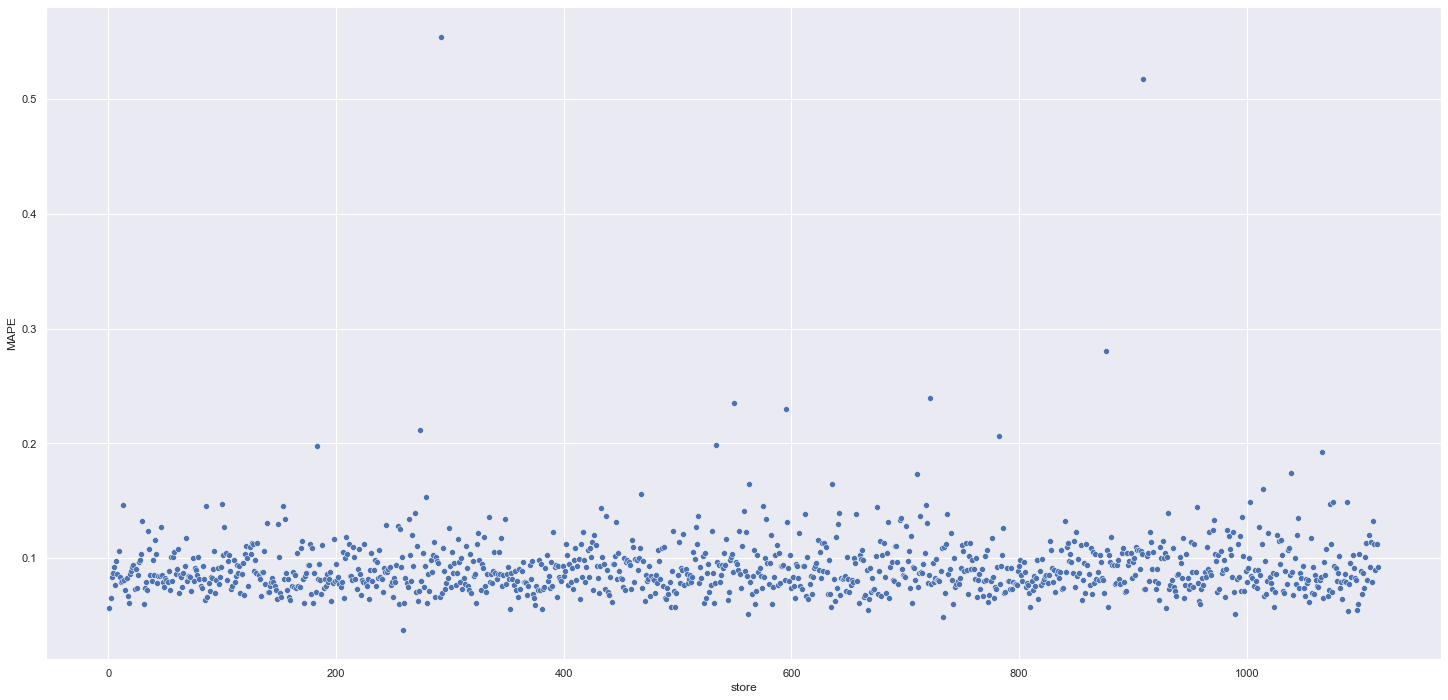

In [248]:
sns.scatterplot( x='store', y='MAPE', data=df92 )


## 9.2 Total performance

In [278]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"$283,242,240.00"
1,worst_scenario,"$282,532,641.95"
2,best_scenario,"$283,951,868.44"


## 9.3 Machine Learning performance

In [251]:
df9['error'] = df9.loc[:, 'sales'] - df9.loc[:, 'predictions']
df9['error_rate'] = df9.loc[:, 'predictions'] / df9.loc[:, 'sales']

C:\Users\Codo\AppData\Local\Temp\ipykernel_18252\2913805899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9.loc[:, 'sales'] - df9.loc[:, 'predictions']
C:\Users\Codo\AppData\Local\Temp\ipykernel_18252\2913805899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9.loc[:, 'predictions'] / df9.loc[:, 'sales']


<AxesSubplot:xlabel='predictions', ylabel='error'>

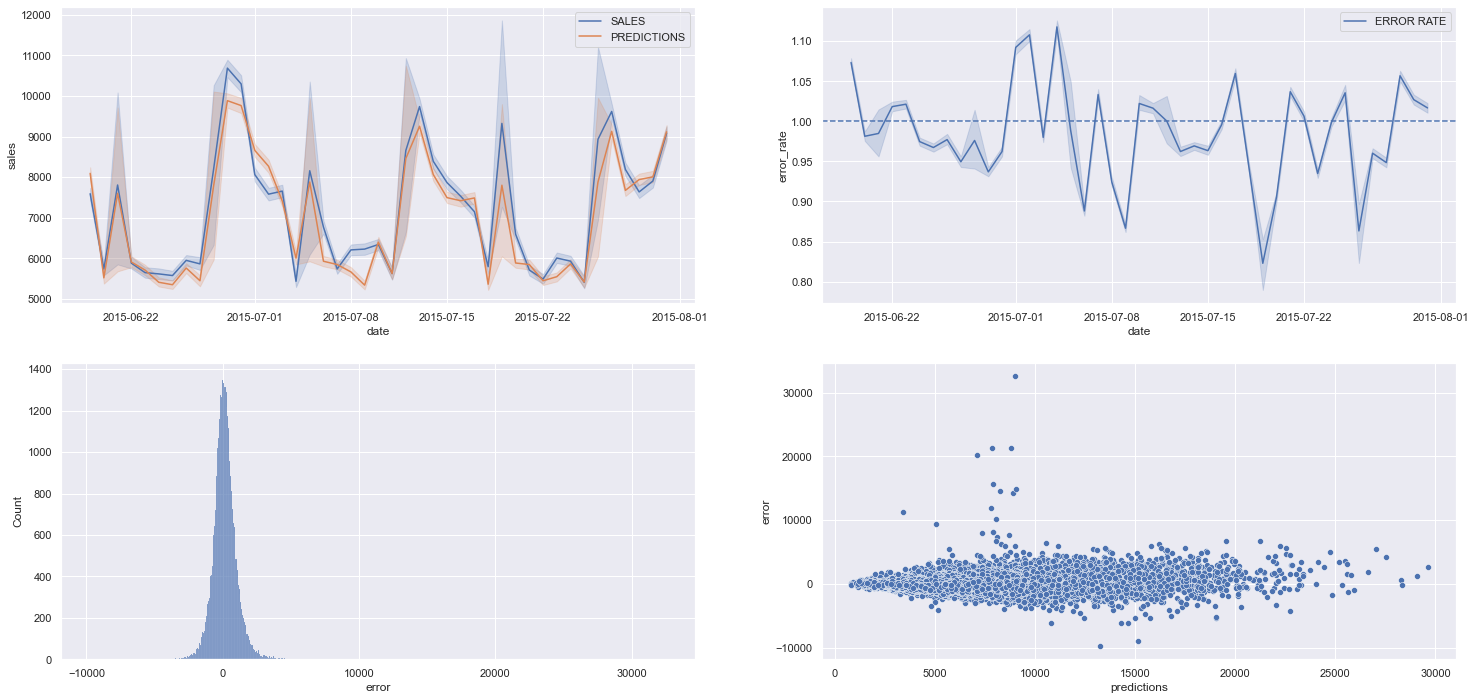

In [269]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9, label='ERROR RATE')
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(data=df9, x='error')

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])


# 10. Deploy

In [127]:
# save trained model
pickle.dump ( model_xgb_tuned, open( '\\Users\Daniel\\Desktop\\repos\\Ds_producao\\model\\model_rossmann.pkl', 'wb' ) )

## 10.1 Rossmann Class

In [154]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
       def __init__(self):
              self.home_path = 'C:\\Users\Daniel\\Desktop\\repos\\Ds_producao\\'
              self.competition_distance_scaler = pickle.load ( open( self.home_path + 'parameter\\competition_distance_scaler.pkl', 'rb' ) )
              self.competition_time_month_scaler = pickle.load ( open( self.home_path + 'parameter\\competition_time_month_scaler.pkl', 'rb' ) )
              self.promo_time_week_scaler = pickle.load ( open( self.home_path +'parameter\\promo_time_week_scaler.pkl', 'rb' ) )
              self.year_scaler = pickle.load ( open( self.home_path + 'parameter\\year_scaler.pkl', 'rb' ) )
              self.store_type_scaler = pickle.load ( open( self.home_path + 'parameter\\store_type_scaler.pkl', 'rb' ) )

       def data_cleaning(self, df1):
                   
              # 1.1 Rename columns
              cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                     'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                     'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval']

              snakecase = lambda x: inflection.underscore(x)
              cols_new = list(map(snakecase, cols_old))

              # rename
              df1.columns = cols_new

              # 1.3 Data types
              df1['date'] = pd.to_datetime(df1['date'])

              # 1.5 Fillout NA
              
              # competition_distance
              df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

              # competition_open_since_month
              df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

              # competition_open_since_year
              df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

              # promo2_since_week
              df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

              # promo2_since_year
              df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

              # promo_interval
              month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
              df1['promo_interval'].fillna(0, inplace=True)
              df1['month_map'] = df1['date'].dt.month.map(month_map)
              df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

              # 1.6 Change Type
              df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
              df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
              df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
              df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

              return df1

       def feature_engineering(self, df2):

              # 2.3 Feature Engineering
              # year
              df2['year'] = df2['date'].dt.year

              # month
              df2['month'] = df2['date'].dt.month

              # day
              df2['day'] = df2['date'].dt.day

              # week of year
              df2['week_of_year'] = df2['date'].dt.isocalendar().week

              # year week
              df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

              # competition since
              df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
              df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

              # promo since
              df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
              df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
              df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

              # assortment
              df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

              # state holiday
              df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

              ## 3.1 Rows filtering
              df2 = df2[(df2['open'] != 0) ]

              ## 3.2 Columns selection
              cols_drop = ['open', 'promo_interval', 'month_map']
              df2 = df2.drop(cols_drop, axis=1)

              return df2

       def data_preparation (self, df5):
              
              # 5.2. Rescaling
              # convert columns int32 to int64 
              df5['week_of_year'] = df5['week_of_year'].astype('int64')
              df5['competition_time_month'] = df5['competition_time_month'].astype('int64')
              df5['promo_time_week'] = df5['promo_time_week'].astype('int64')
              
              # competition distance
              df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)              

              # competition time month
              df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)              

              # promo time week
              df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
              
              # year
              df5['year'] = self.year_scaler.transform(df5[['year']].values)

              # 5.3.1 Enconding
              # state_holiday - one hot encoding
              df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

              # store_type - label encoding
              df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )
           
              # assortment - ordinary enconding
              assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
              df5['assortment'] = df5['assortment'].map(assortment_dict)

              # 5.3.3 Nature Transformation
              # day of week
              df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 )))
              df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 )))

              # month
              df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )))
              df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )))

              # day
              df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ))) 
              df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 )))

              # week of year
              df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 )))
              df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 )))

              cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
              'competition_open_since_month', 'competition_open_since_year', 'promo2',
              'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
              'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos']

              return df5[ cols_selected ]

       def get_prediction (self, model, original_data, test_data):

              # prediction
              pred = model.predict( test_data )
              
              # join pred into the original data
              original_data['prediction'] = np.expm1( pred )

              return original_data.to_json( orient='records', date_format='iso')

              

## 10.2 API Handler

In [188]:
import pickle
import pandas as pd
from flask import Flask, request, Response

# loading model
model = pickle.load( open( 'model/model_rossmann.pkl', 'rb' ) )

# Initialize API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance( test_json, dict):
            test_raw = pd.DataFrame( test_json, index=[0] )
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.0.132:5000/ (Press CTRL+C to quit)


## 10.3 API Tester

In [192]:
import json
# loading dataset
df10 = pd.read_csv('data/test.csv')

In [193]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [194]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )


In [198]:
# API Call
#url = 'http://192.168.0.132:5000/rossmann/predict'
url = 'https://p02-rossmann-prediction.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [199]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )


In [201]:
data

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 23, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 4060.0, "CompetitionOpenSinceMonth": 8.0, "CompetitionOpenSinceYear": 2005.0, "Promo2": 0, "Promo2SinceWeek

In [200]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$317,170.95 in the next 6 weeks
Store Number 22 will sell R$181,160.09 in the next 6 weeks
Store Number 23 will sell R$220,697.59 in the next 6 weeks
